In [1]:
import pandas as pd
import numpy as np

In [2]:
# !pip install contractions

# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')

In [3]:
import contractions
import re
import torch
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split

In [4]:
data = pd.read_csv('data.csv')
data.head()

,review,rating
0,It was nice produt. I like it's design a lot. ...,5
1,awesome sound....very pretty to see this nd th...,5
2,awesome sound quality. pros 7-8 hrs of battery...,4
3,I think it is such a good product not only as ...,5
4,awesome bass sound quality very good bettary l...,5


In [5]:
lem = WordNetLemmatizer()

def preprocess(x):
    x = x.replace("READ MORE","")
    x = x.encode('ascii','ignore')
    x = x.decode()
    x = x.lower()
    x = contractions.fix(x)
    x = ' '.join([word for word in x.split() if not word in set(stopwords.words('english'))])
    x =  re.sub('[^a-zA-Z0-9]', ' ', x)
    x = ' '.join(x.split())
    x = lem.lemmatize(x)
    return x

In [6]:
data['edited_review'] = data['review'].apply(preprocess)
data.edited_review

0       nice produt like design lot easy carry and loo...
1       awesome sound very pretty see nd sound quality...
2       awesome sound quality pros 7 8 hrs battery lif...
3       think good product per quality also design qui...
4       awesome bass sound quality good bettary long l...
                              ...                        
9971                                                 good
9972                       everything amazimg built light
9973                                                 good
9974                             best headphone ever used
9975                                                 nice
Name: edited_review, Length: 9976, dtype: object

### Train test split

In [7]:
X = list(data['edited_review'].values)
y = pd.get_dummies(data['rating']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [8]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

X_train = tokenizer(X_train, truncation=True, padding=True,max_length=30)
X_test = tokenizer(X_test, truncation=True, padding=True,max_length = 30)

In [9]:
X_train[1]

Encoding(num_tokens=30, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [10]:
X_train.update({'labels':y_train})
X_test.update({'labels':y_test})

In [11]:
(X_train.labels[:5]==y_train[:5]).all()

True

In [12]:
num = 3
print(X_train[num].tokens)
print(X_train[num].ids)
print(X_train[num].attention_mask)

['[CLS]', 'best', 'head', '##phones', '1000', 'pro', '##sso', '##und', 'quality', 'good', 'bass', '##de', '##cent', 'battery', 'life', '##com', '##es', 'aux', 'cable', '##con', '##sm', '##ic', 'poor', 'cannot', 'talk', 'low', 'voice', '[SEP]', '[PAD]', '[PAD]']
[101, 2190, 2132, 19093, 6694, 4013, 24137, 8630, 3737, 2204, 3321, 3207, 13013, 6046, 2166, 9006, 2229, 19554, 5830, 8663, 6491, 2594, 3532, 3685, 2831, 2659, 2376, 102, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]


In [13]:
X_train.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [14]:
print(X_train.input_ids[0])
print(X_train[0].ids)
print(X_train[0])

[101, 12476, 4031, 3685, 2444, 2302, 2630, 19392, 7176, 12476, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[101, 12476, 4031, 3685, 2444, 2302, 2630, 19392, 7176, 12476, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Encoding(num_tokens=30, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])


### Torch dataset

In [15]:
class FlipkartDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = FlipkartDataset(X_train)
test_dataset = FlipkartDataset(X_test)

### Model

In [16]:
from transformers import DistilBertForSequenceClassification
import torch.nn as nn
import torch.optim as optim

In [17]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

In [18]:
for layer in model.distilbert.parameters():
    layer.requires_grad = False
print([p.requires_grad for p in model.distilbert.parameters()])
print([p.requires_grad for p in model.pre_classifier.parameters()])
print([p.requires_grad for p in model.classifier.parameters()])

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
[True, True]
[True, True]


In [19]:
n_epochs = 30
batch_size = 16

In [20]:
all_training_losses = []
all_training_accuracies = []
all_test_losses = []
all_test_accuracies = []
training_epoch_loss = []
training_epoch_accuracy = []
test_epoch_loss = []
test_epoch_accuracy = []


for epoch in range(n_epochs):
    batch_loss = 0
    batch_accuracy = 0
    epoch_loss = 0
    epoch_accuracy = 0

    model.train()
    for i in range(0,len(train_dataset), batch_size):
        batch = train_dataset[i:i+batch_size]
        
        optimizer.zero_grad()
        
        outputs = model(batch['input_ids'], batch['attention_mask'])
        
        loss = criterion(outputs.logits, torch.max(batch['labels'], 1)[1])

        batch_loss = loss.item()
        batch_accuracy = (torch.max(outputs.logits, 1)[1] == torch.max(batch['labels'], 1)[1]).sum().item()/batch_size

        all_training_losses.append(batch_loss)
        all_training_accuracies.append(batch_accuracy)
        epoch_loss += batch_loss
        epoch_accuracy += batch_accuracy

        loss.backward()
        optimizer.step()
    training_epoch_loss.append(epoch_loss/(len(train_dataset)/batch_size))
    training_epoch_accuracy.append(epoch_accuracy/(len(train_dataset)/batch_size))

    print(f'Epoch {epoch+0:03}: | Train Loss: {epoch_loss/(len(train_dataset)/batch_size):.5f} | Train Accuracy: {epoch_accuracy/(len(train_dataset)/batch_size):.3f}')

    # model.eval()
    with torch.no_grad():
        outputs = model(test_dataset[:]['input_ids'], test_dataset[:]['attention_mask'])
        loss = criterion(outputs.logits, torch.max(test_dataset[:]['labels'], 1)[1])
        test_epoch_loss.append(loss.item())
        test_epoch_accuracy.append((torch.max(outputs.logits, 1)[1] == torch.max(test_dataset[:]['labels'], 1)[1]).sum().item()/len(X_test))
    print(f'Epoch {epoch+0:03}: | Test Loss: {test_epoch_loss[-1]:.5f} | Test Accuracy: {test_epoch_accuracy[-1]:.3f}')

Epoch 000: | Train Loss: 1.89108 | Train Accuracy: 0.558
Epoch 000: | Test Loss: 1.12795 | Test Accuracy: 200.000
Epoch 001: | Train Loss: 1.20952 | Train Accuracy: 0.571
Epoch 001: | Test Loss: 1.12816 | Test Accuracy: 200.000
Epoch 002: | Train Loss: 1.18745 | Train Accuracy: 0.571
Epoch 002: | Test Loss: 1.12804 | Test Accuracy: 200.000
Epoch 003: | Train Loss: 1.20875 | Train Accuracy: 0.570
Epoch 003: | Test Loss: 1.12952 | Test Accuracy: 200.000
Epoch 004: | Train Loss: 1.18251 | Train Accuracy: 0.571
Epoch 004: | Test Loss: 1.12817 | Test Accuracy: 200.000
Epoch 005: | Train Loss: 1.18262 | Train Accuracy: 0.571
Epoch 005: | Test Loss: 1.12816 | Test Accuracy: 200.000
Epoch 006: | Train Loss: 1.18267 | Train Accuracy: 0.571
Epoch 006: | Test Loss: 1.12815 | Test Accuracy: 200.000
Epoch 007: | Train Loss: 1.18270 | Train Accuracy: 0.571
Epoch 007: | Test Loss: 1.12815 | Test Accuracy: 200.000
Epoch 008: | Train Loss: 1.21224 | Train Accuracy: 0.570
Epoch 008: | Test Loss: 1.12814

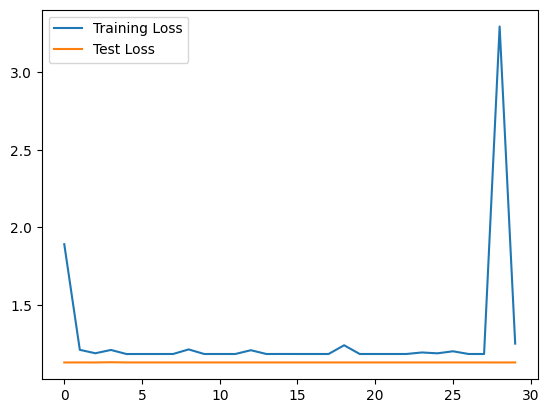

In [21]:
import matplotlib.pyplot as plt
plt.plot(training_epoch_loss, label='Training Loss')
plt.plot(test_epoch_loss, label='Test Loss')
plt.legend();

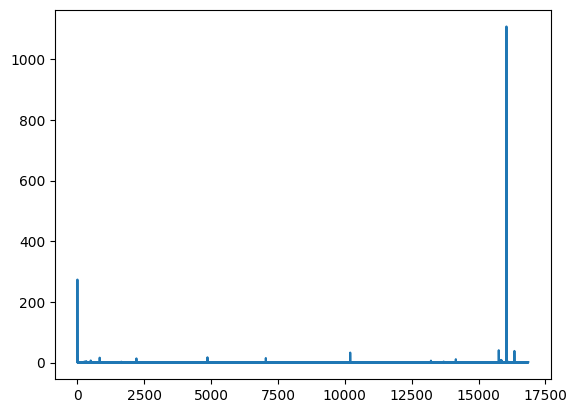

In [22]:
import matplotlib.pyplot as plt
plt.plot(all_training_losses, label='Training Loss');
# plt.plot(test_epoch_loss, label='Test Loss');

In [23]:
len(all_training_losses), len(training_epoch_loss)

(16860, 30)

In [25]:
model.distilbert

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

### END